# King County Millenial homeowner program

**Buying a property in King County recommendations for Millennials**

**Authors:** Hanis Zulmuthi, Greg Burgess, Kyle Weesner

***March 2022***


<img src="https://www.condosky.com/wp-content/uploads/2019/06/Young-Families-Condos-Toronto-e1561577724820.jpg" alt="A picture of a multiracial family sitting on the floor together surrounded by moving boxes" title="" />

# Overview

King County in Washington State is growing in population made up of millenials and generation Z who either grew up or migrated to the area and found life in the region. We, the Data Analysts at the Greek Honey real estate are woking on building a model that predicts house prices in King county with the goal to help folks from the demographic to find their dream house that fits their lifestyle and their pockets! 

# ADD A SUMMARY OF RESULTS HERE

## Business Problem

Housing market in King County region, especially in the major cities such as Seattle, are becoming more and more financially inaccessible for many demographics. The demographic of interest for our real-estate is millenials who are building their career, family and trying to break into the housing market to have a stable housing for themselves. With our house price predicition model, we will help them to find the market value of their ideal house that are in proximity to city centers.

## Data Understanding

### 1. King County Housing data ([kc_house_data.csv](https://github.com/hanis-z/Phase-2-project/blob/main/data/kc_house_data.csv))
**Source:** This data was provided to us by Flatiron School. This data file is available in the project repo in the folder "data". 

**Contents:**

### 2. Incorporated & Unincorporated cities in King county
**Source:** We downloaded this data from [King County GIS website]( https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::cities-and-unincorporated-king-county-city-kc-area/explore?location=47.430582%2C-121.809200%2C10.02). The data is also easily accessible in our project repo in the folder "data".

**Contents:**

### 3. Neighborhood Map of Seattle
**Source:** We attained this data from [Seattle city GIS website](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43]). This data is also easily accessible in our project repo in the folder "data".

**Contents:**


### Importing python libraries required for the analysis.

**Note:** To ensure that all packages are loaded successfully, please ensure that you are in the right python environment. For more reference, refer the (how-to-set-environment)[link to the file] to ensure you have the correct working environment to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#import fiona
#import geopandas as gpd
#from shapely.geometry import Point
#import pyproj
#import folium

import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from pandas.api.types import is_numeric_dtype


### Define Helper Functions for analysis

In [2]:
def dataframe_info(df):
    '''
    Takes Pandas dataframe (df). Prints number of rows, number of columns, and three sample rows.
    Returns list of numerical columns and list of non-numerical columns.
    '''
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    object_cols  = df.select_dtypes(exclude=np.number).columns.tolist()

    nrows, ncol = df.shape
    nmid = nrows // 2
    
    print(f"Dimensions: {nrows} rows and {ncol} columns")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {len(object_cols)}")

    display(df.iloc[[0,nmid,nrows-1]]) # show three rows: first, mid, and last

    return numeric_cols, object_cols

In [3]:
def cleaned_column_names(column_list):
    '''
    Takes list of column names (e.g. from df.columns). 
    Returns list of cleaned column names that can be assigned to DataFrame.
    Usage: df.columns = cleaned_column_names(df.columns)
    '''
    return [name.strip().lower().replace(' ','').replace('-', '_') for name in column_list]

## Data Exploration & Preparation


### Load King County Housing data

In [4]:
housing_df = pd.read_csv('../data/housing_gdf_complete.csv')
#housing_df= gpd.GeoDataFrame(housing_df, crs="EPSG:4326")

In [5]:
dataframe_info(housing_df)

Dimensions: 21596 rows and 28 columns
Numeric columns: 17
Object columns: 11


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,coord,geometry,city,dist_seattle,neighborhood,in_seattle
0,0,8856004730,9/17/2014,199950.0,2,2.75,1590,20917,1.5,NO,...,47.2786,-122.250,1310,6000,"(-122.25, 47.2786)",POINT (392815.9311460542 31962.040946318088),Algona,38586.298196,NaN,False
10798,10798,7237500590,11/17/2014,1320000.0,4,5.25,6110,10369,2.0,NO,...,47.5285,-122.135,4190,10762,"(-122.135, 47.5285)",POINT (401985.90108066204 59588.48465827319),Newcastle,19145.331588,NaN,False
21595,21595,9808100150,4/2/2015,3350000.0,5,3.75,5350,15360,1.0,NO,...,47.6480,-122.218,3740,15940,"(-122.218, 47.648)",POINT (395975.83394082234 72981.52286293103),Yarrow Point,10564.303190,NaN,False


(['Unnamed: 0',
  'id',
  'price',
  'bedrooms',
  'bathrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'sqft_above',
  'yr_built',
  'yr_renovated',
  'zipcode',
  'lat',
  'long',
  'sqft_living15',
  'sqft_lot15',
  'dist_seattle'],
 ['date',
  'waterfront',
  'view',
  'condition',
  'grade',
  'sqft_basement',
  'coord',
  'geometry',
  'city',
  'neighborhood',
  'in_seattle'])

In [6]:
housing_df['dist_seattle'] = housing_df['dist_seattle']/1000

### Load shapefile data for cities in King county

In [7]:
#Read the file in using geopandas
#kc_cities_gdf = gpd.read_file('data/Cities_and_Unincorporated_King_County___city_kc_area/Cities_and_Unincorporated_King_County___city_kc_area.shp')


In [8]:
#kc_cities_gdf.info()

In [9]:
#kc_cities_gdf.head()

#### Note

Unincorporated cities in King County is labeled "King County" in the dataset. King County's official definition of Unincorporated cities is as follows:

"Rural unincorporated King County covers central and eastern King County and Vashon Island – areas outside the Urban Growth Boundary. These areas are desig- nated Rural, Agricultural or Forest Resource by the King County Comprehensive Plan."

We will rename unincorporated cities in king county to "Uincorporated City"

In [10]:
#View cities
#kc_cities_gdf['CITYNAME'].unique()

In [11]:
#Rename "King County" to "Unincorporated City"
#kc_cities_gdf['CITYNAME'] = kc_cities_gdf['CITYNAME'].str.replace('King County', 'Unincorporated City')

#Do a sniff test
#kc_cities_gdf['CITYNAME'].unique()

We want our model to incorporate distance of properties from Seattle city center in predicting house price. So, here, we'll find the coordinates of the center of the cities.

In [12]:
#Get centroids of all cities in King County
#kc_cities_gdf['centroid'] = kc_cities_gdf.centroid

#Sniff test
#kc_cities_gdf.head()

### [Seattle Neighborhood Data](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43])

We would also like to explore how housing price within neighborhoods in Seattle vary, as an additional tool to help our clients decide where their ideal home location would be. 

So let's find the neighborhood the properties are in for the properties in Seattle.

#### Load Seattle Neighborhood data

In [13]:
#Load data using geopandas
#neighborhood_gdf = gpd.read_file('data/Neighborhood_Map_Atlas_Districts/Neighborhood_Map_Atlas_Districts.shp')



In [14]:
#Sniff test
#neighborhood_gdf.head()

In [15]:
#View the list of neighborhoodabs
#neighborhood_gdf['L_HOOD'].unique()

## Data Mapping

In [16]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21596 non-null  int64  
 1   id             21596 non-null  int64  
 2   date           21596 non-null  object 
 3   price          21596 non-null  float64
 4   bedrooms       21596 non-null  int64  
 5   bathrooms      21596 non-null  float64
 6   sqft_living    21596 non-null  int64  
 7   sqft_lot       21596 non-null  int64  
 8   floors         21596 non-null  float64
 9   waterfront     19221 non-null  object 
 10  view           21533 non-null  object 
 11  condition      21596 non-null  object 
 12  grade          21596 non-null  object 
 13  sqft_above     21596 non-null  int64  
 14  sqft_basement  21596 non-null  object 
 15  yr_built       21596 non-null  int64  
 16  yr_renovated   17754 non-null  float64
 17  zipcode        21596 non-null  int64  
 18  lat   

In [17]:
#seattle_centroid = kc_cities_gdf[kc_cities_gdf['CITYNAME']=='Seattle']
#seattle_centroid = seattle_centroid.iloc[0,-1]

In [18]:
#fig, ax = plt.subplots(figsize = (15,8))
# sns.set(rc = {'figure.figsize':(15,8)})
    
#basemap = kc_cities_gdf.plot(ax=ax,color="lightgrey")
#m = sns.scatterplot(x='long', y='lat', size='sqft_living', hue='price', palette="magma", sizes = (20,400), data=housing_df)
# c = seattle_centroid.plot(color = 'r')

#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')

#sns.despine()

In [19]:
#housing_df_seattle = housing_df[housing_df['city'] == 'Seattle']
#mean_seattle_neighborhood = housing_df_seattle.groupby('neighborhood').mean()['price']
#neighborhood_gdf_mean = neighborhood_gdf.merge(mean_seattle_neighborhood, left_on='L_HOOD', right_on = 'neighborhood' )

In [20]:
#kc_cities_gdf['CITYNAME'].unique()

In [21]:
#import geoplot as gplt

#fig = plt.figure()



#ax1 = gplt.choropleth(
#    neighborhood_gdf_mean,
#    hue='price',
#    cmap='Reds', linewidth=0.5,
#    edgecolor='white',
#    legend=True
#)

#kc_cities_gdf[kc_cities_gdf['CITYNAME']=='Seattle'].plot(ax = ax1,color="lightgrey", zorder=0)


#ax1.set_title("Mean house price by neighborhood in Seattle")

#plt.show()

## Data Cleaning

### Basement

In [22]:
# sqft_basement should equal difference between sqft_living and sqft_above
sqft_basement_computed = housing_df['sqft_living'] - housing_df['sqft_above']

housing_df['has_basement'] = (sqft_basement_computed > 0).astype(int)

### Yr renovated

In [23]:
housing_df['sold_dt'] = pd.to_datetime(housing_df['date'])
housing_df['sold_year'] = pd.DatetimeIndex(housing_df['sold_dt']).year
housing_df['sold_month'] = pd.DatetimeIndex(housing_df['sold_dt']).month

In [24]:
housing_df['yr_renovated_missing'] = (housing_df['yr_renovated'].isna()).astype(int)
housing_df['yr_renovated'].fillna(0, inplace=True)

housing_df['renovated'] = ((housing_df['sold_year'] - housing_df['yr_renovated']) <= 5).astype(int)

### Age of the house

In [25]:
housing_df['house_age'] = housing_df['sold_year'] - housing_df['yr_built']
housing_df['house_age'].describe()

count    21596.000000
mean        43.323810
std         29.377864
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: house_age, dtype: float64

### View

In [26]:
housing_df['view_missing'] = (housing_df['view'].isna()).astype(int)

In [27]:
housing_df['view'].fillna('NONE', inplace=True)

### Waterfront

In [28]:
housing_df['waterfront_missing'] = (housing_df['waterfront'].isna()).astype(int)
housing_df['waterfront'].fillna('NO', inplace=True)

### Duplicate records (house resold)

In [29]:
print(f"Number of rows:\t\t{len(housing_df['id'])}")
print(f"Number unique:\t\t{len(housing_df['id'].unique())}")
print(f"Number duplicates:\t{sum(housing_df['id'].duplicated() == True)}")

Number of rows:		21596
Number unique:		21419
Number duplicates:	177


In [30]:
housing_df = housing_df.sort_values(by=['sold_year', 'sold_month'])
housing_df['resold'] = housing_df.id.duplicated().astype(int)

### Ratio between bedrooms and bathrooms

In [31]:
housing_df['br_bth'] = housing_df.bedrooms / housing_df.bathrooms

In [32]:
num,obj = dataframe_info(housing_df)

Dimensions: 21596 rows and 39 columns
Numeric columns: 27
Object columns: 12


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sold_dt,sold_year,sold_month,yr_renovated_missing,renovated,house_age,view_missing,waterfront_missing,resold,br_bth
1,1,3356406510,5/30/2014,196440.0,3,2.0,1560,7352,1.0,NO,...,2014-05-30,2014,5,0,0,22,0,0,0,1.50
10749,10749,1023089197,10/7/2014,390000.0,3,2.0,1930,12443,1.0,NO,...,2014-10-07,2014,10,0,0,45,0,0,0,1.50
21594,21594,1925059254,5/7/2015,3000000.0,5,4.0,6670,16481,2.0,NO,...,2015-05-07,2015,5,1,0,8,0,0,0,1.25


In [33]:
housing_df[num].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 1 to 21594
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            21596 non-null  int64  
 1   id                    21596 non-null  int64  
 2   price                 21596 non-null  float64
 3   bedrooms              21596 non-null  int64  
 4   bathrooms             21596 non-null  float64
 5   sqft_living           21596 non-null  int64  
 6   sqft_lot              21596 non-null  int64  
 7   floors                21596 non-null  float64
 8   sqft_above            21596 non-null  int64  
 9   yr_built              21596 non-null  int64  
 10  yr_renovated          21596 non-null  float64
 11  zipcode               21596 non-null  int64  
 12  lat                   21596 non-null  float64
 13  long                  21596 non-null  float64
 14  sqft_living15         21596 non-null  int64  
 15  sqft_lot15         

In [34]:
housing_df[obj].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 1 to 21594
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21596 non-null  object        
 1   waterfront     21596 non-null  object        
 2   view           21596 non-null  object        
 3   condition      21596 non-null  object        
 4   grade          21596 non-null  object        
 5   sqft_basement  21596 non-null  object        
 6   coord          21596 non-null  object        
 7   geometry       21596 non-null  object        
 8   city           21596 non-null  object        
 9   neighborhood   6735 non-null   object        
 10  in_seattle     21596 non-null  bool          
 11  sold_dt        21596 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(10)
memory usage: 2.0+ MB


In [35]:
housing_df['neighborhood'] = housing_df['neighborhood'].fillna('NA')

### In seattle

In [36]:
housing_df['in_seattle'] = housing_df['in_seattle'].astype(int)

Eliminating condition because grade does a better job (Refer Greg's original notebook)

In [111]:
relevant_num_cols = ['bedrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'dist_seattle',
  'has_basement',
  'yr_renovated_missing',
  'house_age',
  'view_missing',
  'waterfront_missing','resold', 'br_bth']

relevant_cat_col =  ['waterfront',
  'zipcode',
  'view',
  'condition',
  'grade',
  'city',
  'neighborhood'
  ]

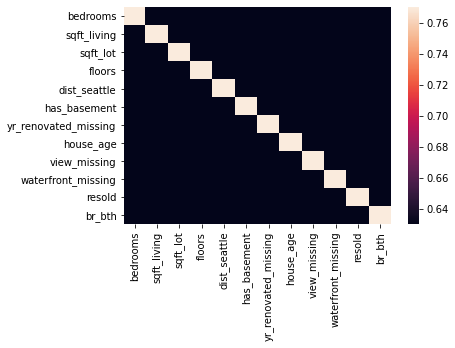

In [112]:
sns.heatmap(housing_df[relevant_num_cols].corr().abs(), vmin=.7, vmax=0.7);

### Train test split

In [113]:
y = housing_df['price']
X = housing_df[relevant_num_cols+relevant_cat_col]

In [114]:
X.head()

,bedrooms,sqft_living,sqft_lot,floors,dist_seattle,has_basement,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth,waterfront,zipcode,view,condition,grade,city,neighborhood
1,3,1560,7352,1.0,38.375160,0,0,22,0,0,0,1.500000,NO,98001,NONE,Average,6 Low Average,Algona,NA
3,4,2020,6236,2.0,38.523083,0,1,12,0,0,0,1.600000,NO,98001,NONE,Average,7 Average,Algona,NA
10,4,2163,5883,2.0,39.138430,0,1,8,0,0,0,1.333333,NO,98001,NONE,Average,7 Average,Algona,NA
13,2,910,22000,1.0,38.654747,0,0,58,0,0,0,2.000000,NO,98001,NONE,Average,6 Low Average,Algona,NA
18,3,1390,16000,1.0,37.351173,0,0,54,0,0,0,3.000000,NO,98001,NONE,Good,6 Low Average,Algona,NA


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## One Hot Encoder

In [116]:
encoder = OneHotEncoder(handle_unknown='ignore',
                        categories='auto') #                        drop='if_binary',

ct = ColumnTransformer(transformers=[('ohe', encoder, relevant_cat_col)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [117]:
X_train_enc.todense()

matrix([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.8       ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.71428571],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.2       ],
        ...,
        [1.        , 0.        , 0.        , ..., 1.        , 0.        ,
         1.71428571],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ],
        [1.        , 0.        , 0.        , ..., 1.        , 0.        ,
         2.        ]])

drop: ohe__x1_NONE, ohe__x2_Average, 'ohe__x3_3 Poor', 'ohe_x3_4 Low', 'ohe_x3_5 Fair', 'ohe_x4_Unincorporated City', 'ohe__x5_nan'


In [119]:
ct.get_feature_names()

['ohe__x0_NO',
 'ohe__x0_YES',
 'ohe__x1_98001',
 'ohe__x1_98002',
 'ohe__x1_98003',
 'ohe__x1_98004',
 'ohe__x1_98005',
 'ohe__x1_98006',
 'ohe__x1_98007',
 'ohe__x1_98008',
 'ohe__x1_98010',
 'ohe__x1_98011',
 'ohe__x1_98014',
 'ohe__x1_98019',
 'ohe__x1_98022',
 'ohe__x1_98023',
 'ohe__x1_98024',
 'ohe__x1_98027',
 'ohe__x1_98028',
 'ohe__x1_98029',
 'ohe__x1_98030',
 'ohe__x1_98031',
 'ohe__x1_98032',
 'ohe__x1_98033',
 'ohe__x1_98034',
 'ohe__x1_98038',
 'ohe__x1_98039',
 'ohe__x1_98040',
 'ohe__x1_98042',
 'ohe__x1_98045',
 'ohe__x1_98052',
 'ohe__x1_98053',
 'ohe__x1_98055',
 'ohe__x1_98056',
 'ohe__x1_98058',
 'ohe__x1_98059',
 'ohe__x1_98065',
 'ohe__x1_98070',
 'ohe__x1_98072',
 'ohe__x1_98074',
 'ohe__x1_98075',
 'ohe__x1_98077',
 'ohe__x1_98092',
 'ohe__x1_98102',
 'ohe__x1_98103',
 'ohe__x1_98105',
 'ohe__x1_98106',
 'ohe__x1_98107',
 'ohe__x1_98108',
 'ohe__x1_98109',
 'ohe__x1_98112',
 'ohe__x1_98115',
 'ohe__x1_98116',
 'ohe__x1_98117',
 'ohe__x1_98118',
 'ohe__x1_98119

In [127]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [128]:
# can display as a dataframe like so
X_train = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names(), index=X_train.index)


X_train.columns

Index(['ohe__x0_NO', 'ohe__x0_YES', 'ohe__x1_98001', 'ohe__x1_98002',
       'ohe__x1_98003', 'ohe__x1_98004', 'ohe__x1_98005', 'ohe__x1_98006',
       'ohe__x1_98007', 'ohe__x1_98008',
       ...
       'sqft_lot', 'floors', 'dist_seattle', 'has_basement',
       'yr_renovated_missing', 'house_age', 'view_missing',
       'waterfront_missing', 'resold', 'br_bth'],
      dtype='object', length=166)

In [129]:
#X_train = X_train.drop(columns=['ohe__x0_NO', 'ohe__x1_NONE', 'ohe__x2_Average', 'ohe__x3_3 Poor', 'ohe__x3_4 Low', 'ohe__x3_5 Fair', 'ohe__x4_Seattle', 'ohe__x5_NA'])

In [130]:
X_train.columns = cleaned_column_names([x.replace('ohe__','').replace('x0','waterfront').replace('x1','zip').replace('x2','view').replace('x3','condition').replace('x4','grade').replace('x5','city').replace('x6','neighborhood') for x in list(X_train.columns)])

In [131]:
train_df = pd.concat([X_train,y_train], axis=1)
train_df.corr().abs()['price'].sort_values()

grade_8good                        0.000578
zip_98072                          0.000932
city_normandypark                  0.001801
zip_98065                          0.001883
neighborhood_downtown              0.002000
neighborhood_interbay              0.002196
city_snoqualmie                    0.003404
city_huntspoint                    0.003570
zip_98136                          0.003711
neighborhood_northwest             0.003833
condition_average                  0.005216
zip_98024                          0.005721
city_lakeforestpark                0.005834
neighborhood_universitydistrict    0.006265
grade_3poor                        0.006397
neighborhood_westseattle           0.006842
city_woodinville                   0.006881
zip_98034                          0.008589
yr_renovated_missing               0.009084
zip_98011                          0.011140
zip_98007                          0.011358
waterfront_missing                 0.012658
city_bothell                    

In [132]:
def build_model(X_train, X_test, y_train, y_test):
    
    """
    Build a regression model
    
    """
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    R2_train = lr.score(X_train,y_train)
    R2_test = lr.score(X_test,y_test)


    yhat_train = lr.predict(X_train)
    train_rmse = mean_squared_error(y_train, yhat_train, squared = False)

    yhat_test = lr.predict(X_test)
    test_rmse = mean_squared_error(y_test, yhat_test, squared = False)
    
    print(f'Train R2: {baseline_lr.score(X1_train,y_train)}')
    print(f'Test R2: {baseline_lr.score(X1_test,y_test)}')
    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    
    return R2_train, R2_test, train_rmse, test_rmse


In [133]:
#Build baseline model

X1_train = X_train[['sqft_living']]
X1_test = X_test[['sqft_living']]

baseline_lr = LinearRegression()
baseline_lr.fit(X1_train,y_train)

print(f'Baseline_train R2: {baseline_lr.score(X1_train,y_train)}')
print(f'Baseline_test R2: {baseline_lr.score(X1_test,y_test)}')

yhat_train = baseline_lr.predict(X1_train)
train_rmse = mean_squared_error(y_train, yhat_train, squared = False)
print(f'Train RMSE: {train_rmse}')

yhat_test = baseline_lr.predict(X1_test)
test_rmse = mean_squared_error(y_test, yhat_test, squared = False)
print(f'Test RMSE: {test_rmse}')



Baseline_train R2: 0.49444009161840075
Baseline_test R2: 0.48894642634551366
Train RMSE: 259759.39782929272
Test RMSE: 265494.00217863


In [135]:
X_train.head()


,waterfront_no,waterfront_yes,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,view_average,view_excellent,view_fair,view_good,view_none,condition_average,condition_fair,condition_good,condition_poor,condition_verygood,grade_10verygood,grade_11excellent,grade_12luxury,grade_13mansion,grade_3poor,grade_4low,grade_5fair,grade_6lowaverage,grade_7average,grade_8good,grade_9better,city_algona,city_auburn,city_beauxarts,city_bellevue,city_blackdiamond,city_bothell,city_burien,city_carnation,city_clydehill,city_covington,city_desmoines,city_duvall,city_enumclaw,city_federalway,city_huntspoint,city_issaquah,city_kenmore,city_kent,city_kirkland,city_lakeforestpark,city_maplevalley,city_medina,city_mercerisland,city_milton,city_newcastle,city_normandypark,city_northbend,city_pacific,city_redmond,city_renton,city_sammamish,city_seatac,city_seattle,city_shoreline,city_skykomish,city_snoqualmie,city_tukwila,city_unincorporatedcity,city_woodinville,city_yarrowpoint,neighborhood_ballard,neighborhood_beaconhill,neighborhood_capitolhill,neighborhood_cascade,neighborhood_centralarea,neighborhood_delridge,neighborhood_downtown,neighborhood_greaterduwamish,neighborhood_interbay,neighborhood_lakecity,neighborhood_magnolia,neighborhood_na,neighborhood_northcentral,neighborhood_northeast,neighborhood_northgate,neighborhood_northwest,neighborhood_queenanne,neighborhood_rainiervalley,neighborhood_sewardpark,neighborhood_universitydistrict,neighborhood_westseattle,bedrooms,sqft_living,sqft_lot,floors,dist_seattle,has_basement,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth
16715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1380.0,953.0,3.0,5.194786,0.0,0.0,8.0,0.0,0.0,0.0,0.800000
128,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1600.0,7500.0,1.0,39.052771,0.0,0.0,17.0,0.0,0.0,0.0,1.714286
8422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [ ]:
X2_train = X_train[['sqft_living','bedrooms', ]]
#X2_test = X_test[['sqft_living','bedrooms']]

model_1_r2_train, model_1_r2_test, train_rmse, test_rmse = build_model(X2_train,X2_test,y_train,y_test)


In [52]:
model1_formula = 'price ~ sqft_living'
model1_mod = ols(model1_formula, train_df).fit()
model1_mod_summary = model1_mod.summary()
model1_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.415e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:12:24   Log-Likelihood:            -2.0092e+05
No. Observations:               14469   AIC:                         4.019e+05
Df Residuals:                   14467   BIC:                         4.019e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.087e+04   5363.580     -7.620      0.000   -5.14e+04   -3.04e+04
sqft_living   280.0996      2.355    118.949      0.000     275.484     284.715
==============================================================================
Omnibus:                     9686.217   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           324867.253
Skew:                           2.747   Prob(JB):                         0.00
Kurtosis:                      25.554   Cond. No.                     5.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
# drop 'grade_7average', 
model2_formula = model1_formula + " + \
'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', \
'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', \
'grade_8good', 'grade_9better'\
"

In [96]:
print (model2_formula)

price ~ sqft_living + 'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', 'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', 'grade_8good', 'grade_9better'


In [88]:
model2_formula = model2_formula.replace("'", "").replace(',', " + ")

In [89]:
model2_formula = 'price ~ ' + model2_formula
model2_mod = ols(model2_formula, train_df).fit()
model2_mod_summary = model2_mod.summary()
model2_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     1792.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:26:59   Log-Likelihood:            -1.9963e+05
No. Observations:               14469   AIC:                         3.993e+05
Df Residuals:                   14457   BIC:                         3.994e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.346e+05   6552.057     20.547      0.000    1.22e+05    1.47e+05
sqft_living         159.5267      3.420     46.651      0.000     152.824     166.230
grade_10verygood   3.822e+05    1.1e+04     34.810      0.000    3.61e+05    4.04e+05
grade_11excellent  6.552e+05   1.75e+04     37.364      0.000    6.21e+05     6.9e+05
grade_12luxury      1.15e+06   3.26e+04     35.235      0.000    1.09e+06    1.21e+06
grade_13mansion    2.238e+06   9.89e+04     22.621      0.000    2.04e+06    2.43e+06
grade_3poor        4.442e+04   2.38e+05      0.187      0.852   -4.22e+05    5.11e+05
grade_4low        -3.057e+04   5.34e+04     -0.573      0.567   -1.35e+05     7.4e+04
grade_5fair       -4.192e+04   1.96e+04     -2.143      0.032   -8.03e+04   -3583.001
grade_6lowaverage -2.264e+04   7306.402     -3.099      0.002    -3.7e+04   -8319.480
grade_8good        6.084e+04   5114.042     11.896      0.000    5.08e+04    7.09e+04
grade_9better      1.838e+05   7606.403     24.161      0.000    1.69e+05    1.99e+05
==============================================================================
Omnibus:                     9567.144   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           360553.384
Skew:                           2.655   Prob(JB):                         0.00
Kurtosis:                      26.872   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#formula =  'price ~ sqft_living + renovated + \
#            grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + \
#            grade_9better + grade_10verygood + grade_11excellent + grade_12luxury'#  + grade_13mansion'

# the independent variables set
y, X = dmatrices(model2_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,10.990781
1,sqft_living,2.518118
2,grade_10verygood,1.579598
3,grade_11excellent,1.441516
4,grade_12luxury,1.182105
5,grade_13mansion,1.039009
6,grade_3poor,1.000383
7,grade_4low,1.006543
8,grade_5fair,1.031544
9,grade_6lowaverage,1.179968


In [101]:
model3_formula = model2_formula + " + \
'waterfront_yes', 'view_average', 'view_excellent', 'view_fair', 'view_good'"


In [102]:
model3_formula = model3_formula.replace("'", "").replace(',', " + ")

In [103]:

model3_mod = ols(model3_formula, train_df).fit()
model3_mod_summary = model3_mod.summary()
model3_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1529.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:40:24   Log-Likelihood:            -1.9869e+05
No. Observations:               14469   AIC:                         3.974e+05
Df Residuals:                   14452   BIC:                         3.975e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.547e+05   6160.101     25.106      0.000    1.43e+05    1.67e+05
sqft_living         142.6608      3.237     44.068      0.000     136.315     149.006
grade_10verygood     3.6e+05   1.03e+04     34.908      0.000     3.4e+05     3.8e+05
grade_11excellent  6.145e+05   1.65e+04     37.315      0.000    5.82e+05    6.47e+05
grade_12luxury     1.093e+06   3.07e+04     35.638      0.000    1.03e+06    1.15e+06
grade_13mansion    2.206e+06   9.29e+04     23.748      0.000    2.02e+06    2.39e+06
grade_3poor        3.316e+04   2.23e+05      0.149      0.882   -4.04e+05     4.7e+05
grade_4low        -5.386e+04      5e+04     -1.077      0.282   -1.52e+05    4.42e+04
grade_5fair       -6.696e+04   1.83e+04     -3.651      0.000   -1.03e+05    -3.1e+04
grade_6lowaverage -3.315e+04   6851.805     -4.839      0.000   -4.66e+04   -1.97e+04
grade_8good        5.835e+04   4797.394     12.164      0.000     4.9e+04    6.78e+04
grade_9better      1.798e+05   7137.482     25.192      0.000    1.66e+05    1.94e+05
waterfront_yes      6.35e+05   2.72e+04     23.351      0.000    5.82e+05    6.88e+05
view_average       1.027e+05   9025.657     11.374      0.000     8.5e+04     1.2e+05
view_excellent     2.996e+05   1.85e+04     16.212      0.000    2.63e+05    3.36e+05
view_fair          1.785e+05   1.53e+04     11.683      0.000    1.49e+05    2.08e+05
view_good          1.637e+05   1.22e+04     13.388      0.000     1.4e+05    1.88e+05
==============================================================================
Omnibus:                     7982.194   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           228449.467
Skew:                           2.108   Prob(JB):                         0.00
Kurtosis:                      22.004   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
model3_mod.params

Intercept            1.546530e+05
sqft_living          1.426608e+02
grade_10verygood     3.599985e+05
grade_11excellent    6.145401e+05
grade_12luxury       1.093235e+06
grade_13mansion      2.206488e+06
grade_3poor          3.316336e+04
grade_4low          -5.386075e+04
grade_5fair         -6.696497e+04
grade_6lowaverage   -3.315272e+04
grade_8good          5.835442e+04
grade_9better        1.798081e+05
waterfront_yes       6.349949e+05
view_average         1.026597e+05
view_excellent       2.996194e+05
view_fair            1.784866e+05
view_good            1.636868e+05
dtype: float64

In [104]:
y, X = dmatrices(model3_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,11.062622
1,sqft_living,2.569778
2,grade_10verygood,1.587100
3,grade_11excellent,1.447963
4,grade_12luxury,1.189327
5,grade_13mansion,1.043220
6,grade_3poor,1.000384
7,grade_4low,1.006923
8,grade_5fair,1.032786
9,grade_6lowaverage,1.181632


In [107]:
model4_formula = model3_formula + " + \
        'dist_seattle', \
        'neighborhood_ballard', 'neighborhood_beaconhill', \
       'neighborhood_capitolhill', 'neighborhood_cascade', \
       'neighborhood_centralarea', 'neighborhood_delridge', \
       'neighborhood_downtown', 'neighborhood_greaterduwamish', \
       'neighborhood_interbay', 'neighborhood_lakecity', \
       'neighborhood_magnolia', 'neighborhood_northcentral', \
       'neighborhood_northeast', 'neighborhood_northgate', \
       'neighborhood_northwest', 'neighborhood_queenanne', \
       'neighborhood_rainiervalley', 'neighborhood_sewardpark', \
       'neighborhood_universitydistrict', 'neighborhood_westseattle' \
"



In [108]:
model4_formula = model4_formula.replace("'", "").replace(',', " + ")

In [109]:
model4_mod = ols(model4_formula, train_df).fit()
model4_mod_summary = model4_mod.summary()
model4_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1122.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:47:32   Log-Likelihood:            -1.9606e+05
No. Observations:               14469   AIC:                         3.922e+05
Df Residuals:                   14431   BIC:                         3.925e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2.904e+05   7359.869     39.452      0.000    2.76e+05    3.05e+05
sqft_living                       169.8738      2.758     61.600      0.000     164.468     175.279
grade_10verygood                 3.055e+05   8663.097     35.270      0.000    2.89e+05    3.23e+05
grade_11excellent                 5.39e+05   1.38e+04     39.037      0.000    5.12e+05    5.66e+05
grade_12luxury                   9.947e+05   2.56e+04     38.792      0.000    9.44e+05    1.04e+06
grade_13mansion                  1.939e+06   7.77e+04     24.952      0.000    1.79e+06    2.09e+06
grade_3poor                      3.824e+05   1.86e+05      2.057      0.040     1.8e+04    7.47e+05
grade_4low                       3.427e+04   4.18e+04      0.821      0.412   -4.76e+04    1.16e+05
grade_5fair                     -4288.1319   1.53e+04     -0.280      0.780   -3.43e+04    2.58e+04
grade_6lowaverage               -1.042e+04   5796.974     -1.798      0.072   -2.18e+04     938.571
grade_8good                      4.189e+04   4023.624     10.412      0.000     3.4e+04    4.98e+04
grade_9better                    1.472e+05   6001.837     24.526      0.000    1.35e+05    1.59e+05
waterfront_yes                   6.467e+05   2.27e+04     28.490      0.000    6.02e+05    6.91e+05
view_average                      6.68e+04   7590.868      8.800      0.000    5.19e+04    8.17e+04
view_excellent                   2.571e+05   1.55e+04     16.606      0.000    2.27e+05    2.87e+05
view_fair                        1.117e+05   1.29e+04      8.676      0.000    8.65e+04    1.37e+05
view_good                        1.325e+05   1.03e+04     12.902      0.000    1.12e+05    1.53e+05
dist_seattle                    -9418.9171    195.429    -48.196      0.000   -9801.982   -9035.852
neighborhood_ballard              4.25e+04   1.06e+04      3.994      0.000    2.16e+04    6.34e+04
neighborhood_beaconhill         -1.411e+05   1.42e+04     -9.935      0.000   -1.69e+05   -1.13e+05
neighborhood_capitolhill         2.394e+05   1.45e+04     16.451      0.000    2.11e+05    2.68e+05
neighborhood_cascade             6.585e+04   3.55e+04      1.855      0.064   -3721.957    1.35e+05
neighborhood_centralarea         3.978e+04   1.12e+04      3.555      0.000    1.78e+04    6.17e+04
neighborhood_delridge            -1.32e+05   1.08e+04    -12.170      0.000   -1.53e+05   -1.11e+05
neighborhood_downtown           -1.775e+04   1.86e+05     -0.095      0.924   -3.82e+05    3.47e+05
neighborhood_greaterduwamish    -1.701e+05   3.53e+04     -4.814      0.000   -2.39e+05   -1.01e+05
neighborhood_interbay           -2.481e+04    9.3e+04     -0.267      0.790   -2.07e+05    1.58e+05
neighborhood_lakecity           -3.989e+04   1.29e+04     -3.097      0.002   -6.51

In [110]:
y, X = dmatrices(model4_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,22.703642
1,sqft_living,2.681070
2,grade_10verygood,1.610138
3,grade_11excellent,1.463289
4,grade_12luxury,1.194723
5,grade_13mansion,1.048829
6,grade_3poor,1.001349
7,grade_4low,1.008905
8,grade_5fair,1.037397
9,grade_6lowaverage,1.216040


In [ ]:
y, X = dmatrices(model3_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

In [140]:


model5_formula = model4_formula + " + \
zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,\
zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,\
zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,\
zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,\
zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,\
zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,\
zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199\
"

In [141]:
model5_formula = model5_formula.replace("'", "").replace(',', " + ")

In [142]:
model5_mod = ols(model5_formula, train_df).fit()
model5_mod_summary = model5_mod.summary()
model5_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     672.1
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        18:06:57   Log-Likelihood:            -1.9294e+05
No. Observations:               14469   AIC:                         3.861e+05
Df Residuals:                   14362   BIC:                         3.869e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        1.371e+05   2.34e+04      5.850      0.000    9.11e+04    1.83e+05
sqft_living                       156.7978      2.262     69.306      0.000     152.363     161.232
grade_10verygood                 2.345e+05   7262.507     32.295      0.000     2.2e+05    2.49e+05
grade_11excellent                4.259e+05   1.14e+04     37.435      0.000    4.04e+05    4.48e+05
grade_12luxury                   8.232e+05    2.1e+04     39.189      0.000    7.82e+05    8.64e+05
grade_13mansion                  1.797e+06   6.32e+04     28.435      0.000    1.67e+06    1.92e+06
grade_3poor                      1.932e+05   1.51e+05      1.282      0.200   -1.02e+05    4.89e+05
grade_4low                       4.866e+04   3.39e+04      1.436      0.151   -1.78e+04    1.15e+05
grade_5fair                       1.16e+04   1.25e+04      0.926      0.355    -1.3e+04    3.62e+04
grade_6lowaverage                6003.3727   4795.042      1.252      0.211   -3395.528    1.54e+04
grade_8good                      1.973e+04   3344.620      5.899      0.000    1.32e+04    2.63e+04
grade_9better                    1.005e+05   5010.582     20.049      0.000    9.06e+04     1.1e+05
waterfront_yes                   6.513e+05   1.87e+04     34.856      0.000    6.15e+05    6.88e+05
view_average                     7.315e+04   6251.871     11.701      0.000    6.09e+04    8.54e+04
view_excellent                   2.915e+05   1.27e+04     22.969      0.000    2.67e+05    3.16e+05
view_fair                        7.427e+04   1.05e+04      7.065      0.000    5.37e+04    9.49e+04
view_good                        1.516e+05   8445.995     17.946      0.000    1.35e+05    1.68e+05
dist_seattle                    -5083.1564    596.688     -8.519      0.000   -6252.741   -3913.572
neighborhood_ballard             6.509e+04   2.02e+04      3.215      0.001    2.54e+04    1.05e+05
neighborhood_beaconhill         -5.762e+04    2.8e+04     -2.060      0.039   -1.12e+05   -2789.775
neighborhood_capitolhill         -579.3440   3.67e+04     -0.016      0.987   -7.26e+04    7.14e+04
neighborhood_cascade            -3.756e+04   5.17e+04     -0.727      0.467   -1.39e+05    6.37e+04
neighborhood_centralarea        -3.545e+04   3.06e+04     -1.159      0.246   -9.54e+04    2.45e+04
neighborhood_delridge            7996.4497   2.45e+04      0.326      0.744      -4e+04     5.6e+04
neighborhood_downtown           -8.399e+04   1.54e+05     -0.547      0.585   -3.85e+05    2.17e+05
neighborhood_greaterduwamish    -7.327e+04   4.16e+04     -1.760      0.078   -1.55e+05    8311.171
neighborhood_interbay           -2.597e+04   1.92e+05     -0.135      0.892   -4.02e+05     3.5e+05
neighborhood_lakecity            2.819e+04   2.38e+04      1.185      0.236   -1.84

In [143]:
y, X = dmatrices(model5_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,352.155256
1,sqft_living,2.761464
2,grade_10verygood,1.731694
3,grade_11excellent,1.520410
4,grade_12luxury,1.226988
5,grade_13mansion,1.061816
6,grade_3poor,1.006907
7,grade_4low,1.017188
8,grade_5fair,1.061177
9,grade_6lowaverage,1.273243
